In [1]:
import os
import time
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import mglearn

from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR

# Import helperfunctions
from helperfunctions_models import fun_load_file, fun_preprocessing, fun_split_X_y
from helperfunctions_models import fun_convert_time, fun_fit_gridsearch_time
from helperfunctions_models import fun_train_score, fun_test_score, fun_best_model
from helperfunctions_models import fun_feature_weights, plot_feature_importances, plot_heatmap

# Start time count and load data
start_script = time.time()
data = fun_load_file(subfolder_path='..\\01_data\\01_TSP', name='tsp_instances_j_updated.xlsx')
train_data = fun_preprocessing(data)
X, y = fun_split_X_y(train_data)

# Create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Create a smaller train set for svm
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y, test_size=0.99, random_state=0)

# Save number of features and train sizes
n_features = X_train.shape[1]
train_size = f'{int(np.round(100 * len(X_train)/len(X)))} %'
train_size_small = f'{int(np.round(100 * len(X_train_small)/len(X)))} %'

# **A. Instance-based models**
### **1. KNN**

In [2]:
# Grid search cross validation
param_grid = {'n_neighbors': list(np.arange(start=1, stop=11))}

grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid, cv=5,
                    scoring='neg_mean_absolute_percentage_error', 
                    verbose=False, n_jobs=1)
fit_time = fun_fit_gridsearch_time(grid_search, X_train, y_train)

# View results of grid search cross validation
MAPE, RMSE = fun_best_model(grid_search, X_train, y_train, view_results_df=True, return_scores=True)

# Save results to dictionary
results_dict = {}
results_dict['KNN'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit gird searach time': fit_time, 'Train size': train_size}

  CV MAPE train data: 50.18129999999999 %
  CV RMSE train data: 0.0

  Best model / parameter combination:
   {'n_neighbors': 1}

Cross validation scores of all parameter combinations:


,params,mean_test_score
0,{'n_neighbors': 1},-0.501813
1,{'n_neighbors': 2},-0.509022
2,{'n_neighbors': 3},-0.520084
3,{'n_neighbors': 4},-0.527721
4,{'n_neighbors': 5},-0.531984
5,{'n_neighbors': 6},-0.535697
6,{'n_neighbors': 7},-0.539877
7,{'n_neighbors': 8},-0.546254
8,{'n_neighbors': 9},-0.550648
9,{'n_neighbors': 10},-0.555176


# **B. Linear Models**
### **1. Linear Regression**

In [3]:
# Create model
lr = LinearRegression()

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(lr, X_train, y_train, cv=10, return_results=True)

# Save results to dictionary
results_dict = {}
results_dict['Linear Regression'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit gird searach time': computation_time, 'Train size': train_size} #no parameters, no grid search only cv

# Fit model on train set (default parameters) and get top ten absolute feature weights
lr.fit(X_train, y_train)
fun_feature_weights(lr, X_train)

  CV MAPE train data:  16.267400000000002 %
  CV RMSE train data:  3.2755
  CV computation time: 5 sec

Feature weights: 
Mean Distance To Other Customers Ratio      12.127173
Depot Distance Ratio                        11.573717
Gravity Center Distance Ratio                8.181008
Centroid Distance To Depot Ratio             3.064270
4th CCD Ratio                                2.765118
Marginal Costs Ratio                         2.088519
Savings Ratio                                1.770837
Distance To Closest Other Centroid Ratio     1.693506
Distance To Closest Other Cluster Ratio      1.509380
Number Customers                             1.077531
dtype: float64

Bias: 1.879789235845724


**Apply binning (one hot encoding) for most important continuous features**

In [4]:
# Select most important continuous features from script 'feature_selection.ipynb'
continuous_features = ['Depot Distance', '2nd CCD', '3rd CCD', '4th CCD', 'Mean Distance To Other Customers', 'Gravity Center Distance', 'Centroid Distance To Depot',
                       'Savings', 'Marginal Costs', 'Depot Distance Ratio', '4th CCD Ratio', 'Mean Distance To Other Customers Ratio', 'Gravity Center Distance Ratio',
                       'Centroid Distance To Depot Ratio', 'Savings Ratio', 'Marginal Costs Ratio']

# Example with only two bins per feature
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
binned_features = discretizer.fit_transform(X_train[continuous_features])
binned_df = pd.DataFrame(binned_features, columns=[f'{col} binned' for col in continuous_features])
display(X_train[continuous_features[:3]].head(5))
display(binned_df.head(5))

,Depot Distance,2nd CCD,3rd CCD
69677,74.382412,11.977744,39.997353
34646,25.187236,24.128578,26.210727
86125,59.381098,41.508458,51.034661
82264,24.713368,17.435241,22.752606
53677,25.307497,20.672112,23.494538


,Depot Distance binned,2nd CCD binned,3rd CCD binned,4th CCD binned,Mean Distance To Other Customers binned,Gravity Center Distance binned,Centroid Distance To Depot binned,Savings binned,Marginal Costs binned,Depot Distance Ratio binned,4th CCD Ratio binned,Mean Distance To Other Customers Ratio binned,Gravity Center Distance Ratio binned,Centroid Distance To Depot Ratio binned,Savings Ratio binned,Marginal Costs Ratio binned
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
# Binning the continuous features to create a data frame with the bin affiliation for each feature (value between 0 and 29)
discretizer = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='uniform')
binned_features = discretizer.fit_transform(X_train[continuous_features])
binned_df = pd.DataFrame(binned_features, columns=[f'{col} binned' for col in continuous_features])

# One-Hot Encoding the binned features
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(binned_df)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(binned_df.columns))

# Combine with original data
X_train_onehot = pd.concat([X_train.reset_index(drop=True), one_hot_encoded_df], axis=1)
display(X_train_onehot.head())

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(model=LinearRegression(), X_train=X_train_onehot, y_train=y_train, cv=10, return_results=True)

,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,...,Marginal Costs Ratio binned_20.0,Marginal Costs Ratio binned_21.0,Marginal Costs Ratio binned_22.0,Marginal Costs Ratio binned_23.0,Marginal Costs Ratio binned_24.0,Marginal Costs Ratio binned_25.0,Marginal Costs Ratio binned_26.0,Marginal Costs Ratio binned_27.0,Marginal Costs Ratio binned_28.0,Marginal Costs Ratio binned_29.0
0,7514,13,10.757862,59.017647,85.136678,58.286327,74.382412,9.328826,11.977744,39.997353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4465,10,48.887571,89.321664,71.930472,79.152025,25.187236,5.800107,24.128578,26.210727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8724,14,94.158761,18.714924,62.519411,68.964961,59.381098,15.401211,41.508458,51.034661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8448,14,7.638488,88.621244,19.511578,66.946829,24.713368,17.196267,17.435241,22.752606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6224,12,76.713851,70.103436,70.494633,94.634859,25.307497,5.802874,20.672112,23.494538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


  CV MAPE train data:  14.8469 %
  CV RMSE train data:  2.9571
  CV computation time: 21 sec


**Add logarithm for most important continuous features**

In [6]:
# Compute log for the continuous features from above
log_df = np.log(X_train[continuous_features] + 1)
log_df.columns = [f'{i} log' for i in continuous_features]

# Add log features to the one hot encoded X_train data frame
X_train_onehot_log = pd.concat([X_train_onehot, log_df.reset_index(drop=True)], axis=1)
display(X_train_onehot_log.head())

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(LinearRegression(), X_train_onehot_log, y_train, cv=10, return_results=True)

,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,...,Centroid Distance To Depot log,Savings log,Marginal Costs log,Depot Distance Ratio log,4th CCD Ratio log,Mean Distance To Other Customers Ratio log,Gravity Center Distance Ratio log,Centroid Distance To Depot Ratio log,Savings Ratio log,Marginal Costs Ratio log
0,7514,13,10.757862,59.017647,85.136678,58.286327,74.382412,9.328826,11.977744,39.997353,...,4.341897,1.718735,1.718735,0.890542,0.849534,0.696529,0.692217,0.945824,0.581511,0.575330
1,4465,10,48.887571,89.321664,71.930472,79.152025,25.187236,5.800107,24.128578,26.210727,...,2.580397,1.363930,1.363930,0.678507,0.629986,0.683378,0.692274,0.562741,0.299593,0.294629
2,8724,14,94.158761,18.714924,62.519411,68.964961,59.381098,15.401211,41.508458,51.034661,...,4.019136,2.712241,2.971768,0.838795,0.855436,0.798008,0.898942,0.824521,0.958654,0.929330
3,8448,14,7.638488,88.621244,19.511578,66.946829,24.713368,17.196267,17.435241,22.752606,...,3.332876,3.133457,3.168838,0.460929,0.780772,0.764827,0.873218,0.555607,1.095181,0.983602
4,6224,12,76.713851,70.103436,70.494633,94.634859,25.307497,5.802874,20.672112,23.494538,...,3.519972,1.866803,1.866803,0.392131,0.548945,0.646525,0.663588,0.490007,0.348622,0.328442


  CV MAPE train data:  14.5823 %
  CV RMSE train data:  2.8765
  CV computation time: 16 sec


**Interactions and Polynomials**

In [135]:
# Generate interaction and polynomial features with all polynomial combinations of the features up to the specified degree (for all continuous features from above)
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
poly.fit(X_train[continuous_features])
poly_df = pd.DataFrame(poly.transform(X_train[continuous_features]))

# Add polynomial features to the X_train data frame
X_train_poly = pd.concat([X_train_onehot[[i for i in X_train_onehot.columns if i not in continuous_features]].reset_index(drop=True), poly_df], axis=1)
X_train_poly.columns = X_train_poly.columns.astype(str)
display(X_train_poly.head())

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(LinearRegression(), X_train_poly, y_train, cv=10, return_results=True)

,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Closest Customer Distance (CCD),Cluster,Core Point,Outlier,...,958,959,960,961,962,963,964,965,966,967
0,7514,13,10.757862,59.017647,85.136678,58.286327,9.328826,0,1,0,...,3.906490,1.956401,1.929061,0.979781,0.966089,0.952589,0.490682,0.483825,0.477064,0.470397
1,4465,10,48.887571,89.321664,71.930472,79.152025,5.800107,0,1,0,...,0.431185,0.199367,0.195554,0.092181,0.090418,0.088689,0.042622,0.041806,0.041007,0.040223
2,8724,14,94.158761,18.714924,62.519411,68.964961,15.401211,3,0,0,...,2.101025,2.638089,2.514448,3.312438,3.157192,3.009221,4.159164,3.964234,3.778439,3.601352
3,8448,14,7.638488,88.621244,19.511578,66.946829,17.196267,0,1,0,...,0.410169,1.098420,0.924164,2.941533,2.474883,2.082263,7.877335,6.627660,5.576235,4.691611
4,6224,12,76.713851,70.103436,70.494633,94.634859,5.802874,0,1,0,...,0.252830,0.166778,0.155458,0.110015,0.102548,0.095587,0.072571,0.067645,0.063054,0.058774


  CV MAPE train data:  5.3009 %
  CV RMSE train data:  1.213
  CV computation time: 1 min, 16 sec


**Plot data and model**

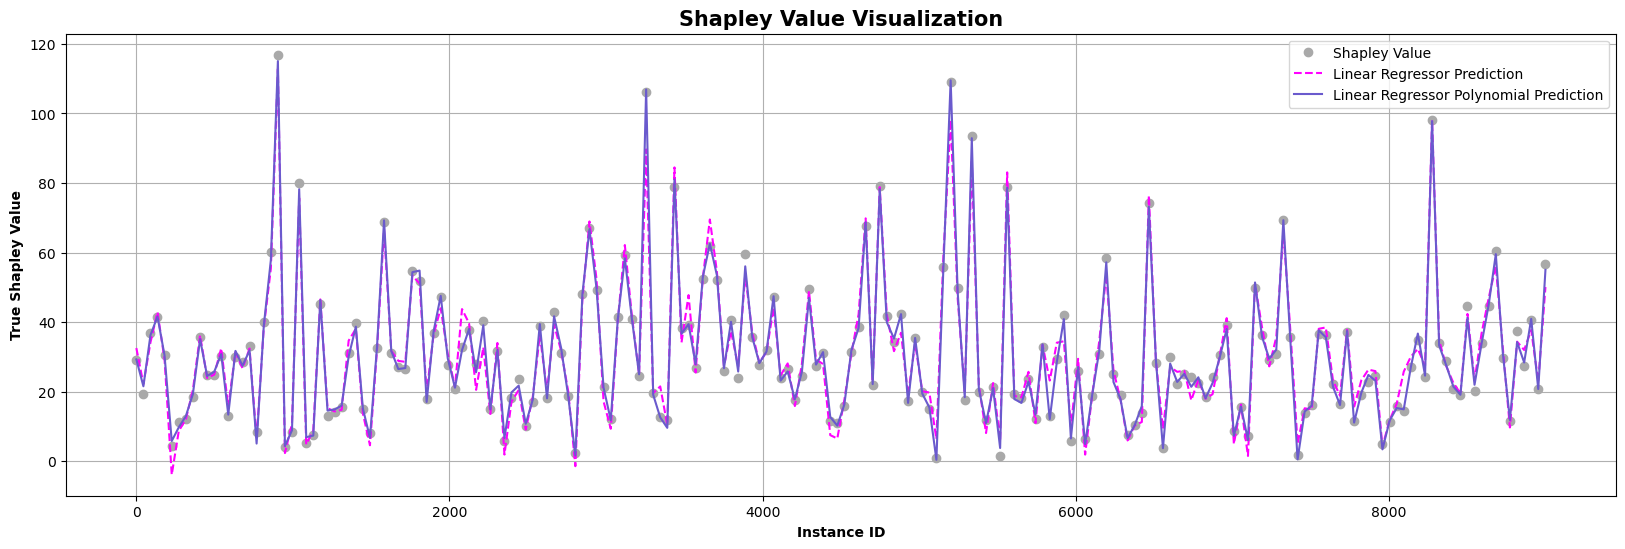

In [145]:
# Create model
lr = LinearRegression()

# Fit model on original train set and make a prediction
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_train)

# Fit model on one hot encoded and polynomial train set and make a prediction
lr.fit(X_train_poly, y_train)
lr_poly_pred = lr.predict(X_train_poly)

# Select 200 instance IDs
line = np.linspace(0, 9000, 200).astype('int')

# Create a plot with 200 True Shapley Values and the predictions from above
plt.figure(figsize=(20, 6))
plt.plot(line, [list(y_train)[i] for i in line], 'o', c='darkgrey', label='Shapley Value')
plt.plot(line, [list(lr_pred)[i] for i in line], '--', c='magenta', label='Linear Regressor Prediction')
plt.plot(line, [list(lr_poly_pred)[i] for i in line], '-', c='slateblue', label='Linear Regressor Polynomial Prediction')
plt.xlabel('Instance ID', size=10, fontweight='bold')
plt.ylabel('True Shapley Value', size=10, fontweight='bold')
plt.title('Shapley Value Visualization', size=15, fontweight='bold')
plt.legend(loc='upper right')
plt.grid()
plt.show()

**Performance on test data**

In [146]:
# Binning the continuous features to create a data frame with the bin affiliation for each feature (value between 0 and 29)
binned_features = discretizer.transform(X_test[continuous_features])
binned_df = pd.DataFrame(binned_features, columns=[f'{col} binned' for col in continuous_features])

# One-Hot Encoding the binned features
one_hot_encoded = encoder.fit_transform(binned_df)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(binned_df.columns))

# Combine with original data
X_test_onehot = pd.concat([X_test.reset_index(drop=True), one_hot_encoded_df], axis=1)
display(X_test_onehot.head())

# Generate interaction and polynomial features
poly_df = pd.DataFrame(poly.transform(X_test[continuous_features]))

# Add polynomial features to the X_train data frame
X_test_poly = pd.concat([X_test_onehot[[i for i in X_test_onehot.columns if i not in continuous_features]].reset_index(drop=True), poly_df], axis=1)
X_test_poly.columns = X_test_poly.columns.astype(str)
display(X_test_poly.head())

# Create model and fit it on train data
lr = LinearRegression()
lr.fit(X_train_poly, y_train)

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_test_score(model=lr, X_test=X_test_poly, y_test=y_test, print_params=True)

,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,...,Marginal Costs Ratio binned_19.0,Marginal Costs Ratio binned_20.0,Marginal Costs Ratio binned_21.0,Marginal Costs Ratio binned_22.0,Marginal Costs Ratio binned_23.0,Marginal Costs Ratio binned_24.0,Marginal Costs Ratio binned_25.0,Marginal Costs Ratio binned_26.0,Marginal Costs Ratio binned_27.0,Marginal Costs Ratio binned_29.0
0,7286,13,2.136172,37.633941,27.534648,30.591561,26.356739,14.626146,34.746778,34.903823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7809,13,51.616609,23.129439,65.216141,48.629875,28.900164,20.947072,22.479158,24.135667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5317,11,66.283154,76.301940,20.937728,69.790523,45.810547,13.821312,28.441339,33.246280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7921,13,8.688830,40.046497,21.406849,66.215842,29.096093,14.695404,30.855726,36.770343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6119,12,11.205565,15.529772,55.538492,67.090208,67.999169,9.014234,13.308571,14.105745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **2. Rigde Regression (L2-Regularization)**

In [26]:
# Grid search cross validation
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(estimator=Ridge(solver='svd'), param_grid=param_grid, cv=5,
                    scoring='neg_mean_absolute_percentage_error', 
                    verbose=False, n_jobs=-1)
fit_time = fun_fit_gridsearch_time(grid_search, X_train_poly, y_train)

# View results of grid search cross validation
MAPE, RMSE = fun_best_model(grid_search, X_train_poly, y_train, view_results_df=True, return_scores=True)

# Save results to dictionary
results_dict['Ridge Regression'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit gird searach time': fit_time, 'Train size': train_size}

# Top ten absolute feature weights
fun_feature_weights(grid_search.best_estimator_, X_train_poly)

  CV MAPE train data: 5.3022 %
  CV RMSE train data: 1.1701

  Best model / parameter combination:
   {'alpha': 1}

Cross validation scores of all parameter combinations:


,params,mean_test_score
0,{'alpha': 0.01},-0.053093
1,{'alpha': 0.1},-0.053026
2,{'alpha': 1},-0.053022
3,{'alpha': 10},-0.053193
4,{'alpha': 100},-0.053277



Feature weights: 
124    6.625034
9      5.624341
887    5.427605
128    5.407168
884    5.395815
127    4.584423
131    4.503447
912    4.448869
668    4.311651
667    4.150556
dtype: float64

Bias: 8.807401617580954


In [29]:
# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(Ridge(alpha=1), X_train_poly, y_train, cv=10, return_results=True)

  CV MAPE train data:  5.2985999999999995 %
  CV RMSE train data:  1.2151
  CV computation time: 28 sec


### **3. Lasso Regression (L1-Regularization)**

In [24]:
# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(Lasso(), X_train_poly, y_train, cv=3, return_results=True)

  CV MAPE train data:  8.062999999999999 %
  CV RMSE train data:  1.8658
  CV computation time: 1 min, 24 sec


In [10]:
# Grid search cross validation
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], #higher alpha means higher regularization and lower model complexity (less overfitting)
              'max_iter': [10000]}

grid_search = GridSearchCV(estimator=Lasso(max_iter=10000), param_grid=param_grid, cv=5,
                    scoring='neg_mean_absolute_percentage_error', 
                    verbose=False, n_jobs=-1)
fit_time = fun_fit_gridsearch_time(grid_search, X_train, y_train)

# View results of grid search cross validation
MAPE, RMSE = fun_best_model(grid_search, X_train, y_train, view_results_df=True, return_scores=True)

# Save results to dictionary
results_dict['Lasso Regression'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit gird searach time': fit_time, 'Train size': train_size}

# Top ten absolute feature weights
fun_feature_weights(grid_search.best_estimator_, X_train)

  CV MAPE train data: 16.4141 %
  CV RMSE train data: 3.2908

  Best model / parameter combination:
   {'alpha': 0.0001, 'max_iter': 10000}

Cross validation scores of all parameter combinations:


c:\Users\dennis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.217e+05, tolerance: 8.063e+02
  model = cd_fast.enet_coordinate_descent(


,params,mean_test_score
0,"{'alpha': 0.0001, 'max_iter': 10000}",-0.164141
1,"{'alpha': 0.001, 'max_iter': 10000}",-0.164253
2,"{'alpha': 0.01, 'max_iter': 10000}",-0.165033
3,"{'alpha': 0.1, 'max_iter': 10000}",-0.168415
4,"{'alpha': 1, 'max_iter': 10000}",-0.205752
5,"{'alpha': 10, 'max_iter': 10000}",-0.211424



Feature weights: 
Depot Distance Ratio                        11.148357
Mean Distance To Other Customers Ratio       8.077256
Gravity Center Distance Ratio                6.691813
4th CCD Ratio                                3.515948
Centroid Distance To Depot Ratio             3.503218
Marginal Costs Ratio                         2.182825
Savings Ratio                                1.805199
Distance To Closest Other Centroid Ratio     1.294574
Distance To Closest Other Cluster Ratio      1.205229
Number Customers                             1.025262
dtype: float64

Bias: -0.5157507615353225

Number of used features: 55
Number of not used features: 1

Not used features: 
Index(['3rd CCD Ratio'], dtype='object')


### **4. Support Vector Machine (SVM)**

Method: StandardScaler()
  CV MAPE train data: 18.4142 %
  CV RMSE train data: 3.2158

  Best model / parameter combination:
   {'svm__C': 1}

Method: MinMaxScaler()
  CV MAPE train data: 18.4884 %
  CV RMSE train data: 3.2019

  Best model / parameter combination:
   {'svm__C': 100}

Method: RobustScaler()
  CV MAPE train data: 18.279799999999998 %
  CV RMSE train data: 3.293

  Best model / parameter combination:
   {'svm__C': 1}


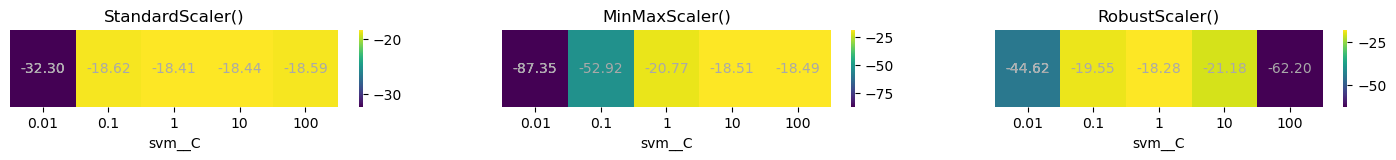

In [7]:
# Create parameter grid
param_grid = {'svm__C': [0.01, 0.1, 1, 10, 100]}

# Compare the scaling methods
scores_list = []
best_MAPE = 100
for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
    
    # Create pipeline
    pipe = Pipeline(steps=[('Scaler', scaler), ('svm', SVR(kernel='linear'))])

    # Grid search cross validation with pipeline as estimator
    grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=3,
                               scoring='neg_mean_absolute_percentage_error', 
                               verbose=False, n_jobs=-1)
    fit_time = fun_fit_gridsearch_time(grid_search, X_train_small, y_train_small)

    # Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
    if (not isinstance(scaler, StandardScaler)): print('')
    print('Method:', scaler)
    MAPE, RMSE = fun_best_model(grid_search, X_train_small, y_train_small, view_results_df=False, return_scores=True)
    
    # Create a data frame with grid search cv results and add it to scores_list
    results_df = pd.DataFrame(grid_search.cv_results_)
    scores_list.append(np.array(results_df['mean_test_score']) * 100)

    # Save best result
    if MAPE < best_MAPE:
        best_MAPE = MAPE
        best_RMSE = RMSE
        best_fit_time = fit_time

# View heatmap of results
plot_heatmap(scores_list=scores_list, param_grid=param_grid, different_scalers=True)

# Save results to dictionary
results_dict['Linear SVM'] = {'MAPE': best_MAPE, 'RMSE': best_RMSE, 'Fit gird searach time': best_fit_time, 'Train size': train_size_small}

# **C. Compare Results**

In [13]:
display(pd.DataFrame(results_dict).sort_values(by='MAPE', axis=1))
print('Total script computation time:', fun_convert_time(start=start_script, end=time.time()))

,Ridge Regression,Lasso Regression,Linear Regression,Linear SVM,KNN
MAPE,16.3474,16.4141,16.4182,18.2798,61.0391
RMSE,3.3093,3.2908,3.2999,3.293,9.4057
Fit gird searach time,1 sec,"3 min, 34 sec",4 sec,34 sec,14 sec
Train size,25 %,25 %,25 %,1 %,25 %


Total script computation time: 18 min, 0 sec


In [9]:
import sys
sys.exit("Stop execution")

SystemExit: Stop execution

c:\Users\dennis\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
